### Instalation

In [50]:
# ! pip install transformers datasets rouge-score python-Levenshtein pandas numpy matplotlib seaborn 

In [51]:
# ! pip install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio


### Importing

In [52]:
import re
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from datasets import load_dataset
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from rouge_score import rouge_scorer
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein

### Loading all the relevant dataset and model


In [53]:
dataset = load_dataset("openai_humaneval")
humaneval = dataset["test"].select(range(20))

model_name = "Salesforce/codet5-base"
tokenizer = AutoTokenizer.from_pretrained(
    model_name
                                          
)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    use_safetensors=True 
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Model loaded on {device}")
print(f"Model parameters: {model.num_parameters():,}")

Model loaded on cuda
Model parameters: 222,882,048


### Implementation

In [54]:
def low_obfuscation(code: str) -> str:
    """
    Apply light obfuscation:
    - Rename variables to generic names (var1, var2, etc.)
    - Keep function names
    - Keep some structure and comments
    """
    obfuscated = code

    param_pattern = r'\(([^)]*)\)'
    params_match = re.search(param_pattern, code)

    if params_match:
        params_str = params_match.group(1)
        params = [p.strip().split(':')[0].strip() for p in params_str.split(',') if p.strip()]

        replacements = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

        for idx, param in enumerate(params):
            if param and param != 'self' and idx < len(replacements):
                obfuscated = re.sub(r'\b' + re.escape(param) + r'\b', replacements[idx], obfuscated)

    obfuscated = re.sub(r'\n\s*\n', '\n', obfuscated)
    
    return obfuscated.strip()

In [55]:
def high_obfuscation(code: str) -> str:
    """
    Apply heavy obfuscation:
    - Replace ALL identifiers with single letters (a, b, c, x, y, z)
    - Remove ALL comments and docstrings
    - Keep only minimal structure
    """

    obfuscated = code

    obfuscated = re.sub(r'"""(.*?)"""', '', obfuscated, flags=re.DOTALL)
    obfuscated = re.sub(r"'''(.*?)'''", '', obfuscated, flags=re.DOTALL)

    obfuscated = re.sub(r'#.*', '', obfuscated)

    param_pattern = r'\(([^)]+)\)'
    params_match = re.search(param_pattern, code)
    if params_match:
        params_str = params_match.group(1)
        params = [p.strip().split(':')[0].strip() for p in params_str.split(',') if p.strip()]
        
        replacements = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        
        for idx, param in enumerate(params):
            if param and param != 'self' and idx < len(replacements):
                obfuscated = re.sub(r'\b' + re.escape(param) + r'\b', replacements[idx], obfuscated)
    
    obfuscated = re.sub(r'\n\s*\n', '\n', obfuscated)
    
    return obfuscated.strip()

#### Generating completion for the hmaneval problems

I have created the fucntion ```generate_completions``` in order to generates code completions for a given prompt using a pre-trained CodeT5 model. This will be used in order to generate completions for the 3 cases:<br>
- ```original```: Which is the existent code from human eval
- ```low obfuscated```: Which represent the code after low obfucation
- ```high obfuscated```: Which represent the code after high obfucation

In [56]:

def generate_completions(prompt: str, max_length=128) -> str:
    '''
    Generate code completions using CodeT5 with task prefix
    '''
    
    inputs = tokenizer(
        prompt, 
        return_tensors="pt", 
        truncation=True, 
        max_length=512,
        padding=True
    )
    inputs = inputs.to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=256,  # Longer output
            min_length=30,   # Ensure minimum length
            num_beams=10,    # More beams for quality
            early_stopping=True,
            temperature=0.8,
            do_sample=False,  # Deterministic with beams
            repetition_penalty=2.0,  # Strong penalty
            no_repeat_ngram_size=4,
            length_penalty=1.5,  # Prefer longer outputs
            forced_bos_token_id=None
        )
    
    completion = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return completion

In [60]:
results = []
problem_id = 0
for problem in humaneval:

    prompt = problem['prompt']
    canonical_solution = problem['canonical_solution']

    #Generate from original
    original_completion = generate_completions(prompt)
    results.append({
        'problem_id': problem_id,
        'task_id': problem['task_id'],
        'obfuscation_level': 'none',
        'prompt': prompt,
        'generated_completion': original_completion,
        'canonical_solution': canonical_solution
    })

    # Generate from low obfuscated 
    low_obf_prompt = low_obfuscation(prompt)
    low_obf_completion = generate_completions(low_obf_prompt)
    results.append({
        'problem_id': problem_id,
        'task_id': problem['task_id'],
        'obfuscation_level': 'low',
        'prompt': low_obf_prompt,
        'generated_completion': low_obf_completion,
        'canonical_solution': canonical_solution
    })
    # Generate from high obfuscated 
    high_obf_prompt = high_obfuscation(prompt)
    high_obf_completion = generate_completions(high_obf_prompt)
    
    results.append({
        'problem_id': problem_id,
        'task_id': problem['task_id'],
        'obfuscation_level': 'high',
        'prompt': high_obf_prompt,
        'generated_completion': high_obf_completion,
        'canonical_solution': canonical_solution
    })
    problem_id += 1
df_results = pd.DataFrame(results)
    

In [ ]:
def calculate_utility_score(generated: str, canonical: str) -> float:
    """Calculate ROUGE-L F1 score between generated and canonical solution"""
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(canonical, generated)
    return scores['rougeL'].fmeasure

print("Calculating utility scores...")
df_results['utility_score'] = df_results.apply(
    lambda row: calculate_utility_score(row['generated_completion'], row['canonical_solution']),
    axis=1
)
print("Utility scores calculated")

Calculating utility scores...
Index(['problem_id', 'task_id', 'obfuscation_level', 'prompt',
       'generated_completion', 'canonical_solution', 'privacy_score',
       'utility_score'],
      dtype='object')
Utility scores calculated


In [61]:
def calculate_privacy_score(obfuscated_prompt: str, original_prompt: str) -> float:
    """Calculate normalized Levenshtein distance (0 = identical, 1 = completely different)"""
    distance = Levenshtein.distance(obfuscated_prompt, original_prompt)
    max_len = max(len(obfuscated_prompt), len(original_prompt))
    if max_len == 0:
        return 0.0
    return distance / max_len

print("Calculating privacy scores...")

# For each result, find the original prompt to compare against
for idx, row in df_results.iterrows():
    prob_id = row['problem_id']
    original_prompt = humaneval[prob_id]['prompt']
    
    privacy_score = calculate_privacy_score(row['prompt'], original_prompt)
    df_results.at[idx, 'privacy_score'] = privacy_score

print("Privacy scores calculated")

Calculating privacy scores...
Privacy scores calculated


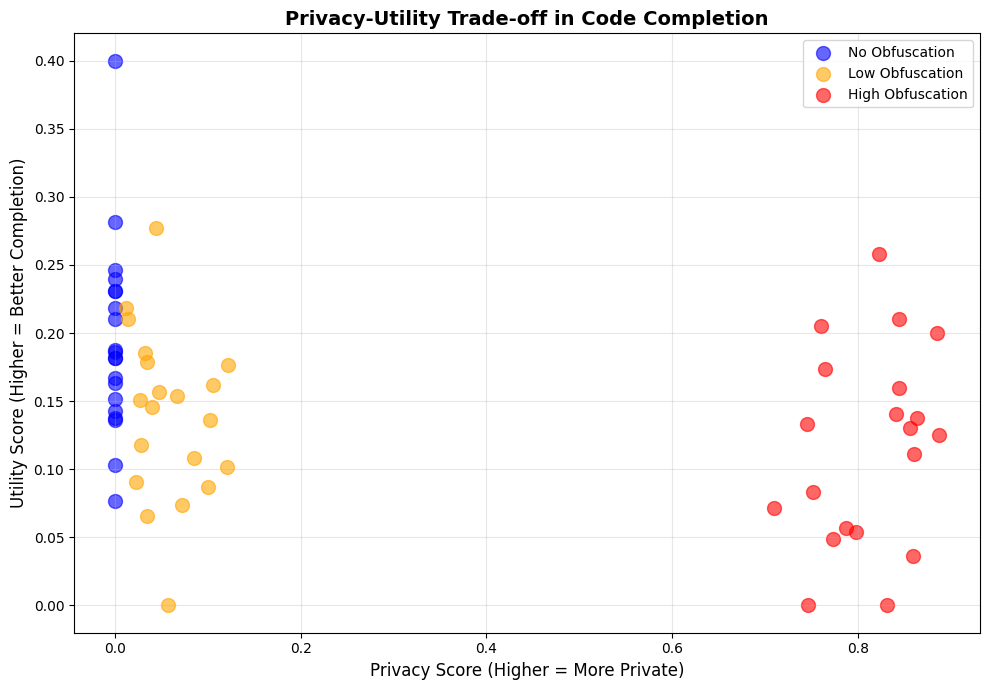

Plot saved as 'privacy_utility_tradeoff.png'


In [66]:
plt.figure(figsize=(10, 7))

# Plot each obfuscation level with different colors
colors = {'none': 'blue', 'low': 'orange', 'high': 'red'}
labels = {'none': 'No Obfuscation', 'low': 'Low Obfuscation', 'high': 'High Obfuscation'}

for level in ['none', 'low', 'high']:
    
    subset = df_results[df_results['obfuscation_level'] == level]
    plt.scatter(
        subset['privacy_score'], 
        subset['utility_score'],
        c=colors[level],
        label=labels[level],
        alpha=0.6,
        s=100
    )

plt.xlabel('Privacy Score (Higher = More Private)', fontsize=12)
plt.ylabel('Utility Score (Higher = Better Completion)', fontsize=12)
plt.title('Privacy-Utility Trade-off in Code Completion', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('privacy_utility_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'privacy_utility_tradeoff.png'")

In [67]:
print("\n" + "="*70)
print("PRIVACY-UTILITY TRADE-OFF ANALYSIS")
print("="*70)

summary = df_results.groupby('obfuscation_level')[['privacy_score', 'utility_score']].agg(['mean', 'std'])
print("\nSummary Statistics:")
print(summary)

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("""
Expected findings:
- No Obfuscation: Low privacy (≈0.0), High utility
- Low Obfuscation: Medium privacy, Medium utility  
- High Obfuscation: High privacy, Low utility

This demonstrates the privacy-utility trade-off:
More privacy protection → Worse code completions
""")


PRIVACY-UTILITY TRADE-OFF ANALYSIS

Summary Statistics:
                  privacy_score           utility_score          
                           mean       std          mean       std
obfuscation_level                                                
high                   0.811875  0.053292      0.116845  0.072260
low                    0.058191  0.035934      0.139823  0.062203
none                   0.000000  0.000000      0.193690  0.070087

INTERPRETATION:

Expected findings:
- No Obfuscation: Low privacy (≈0.0), High utility
- Low Obfuscation: Medium privacy, Medium utility  
- High Obfuscation: High privacy, Low utility

This demonstrates the privacy-utility trade-off:
More privacy protection → Worse code completions

